# Write-up and code for Assignment 6 - Week 3

### To do
- ~~Model Merton's Portfolio problem as an MDP (write the model in LaTeX)~~
- ~~Implement this MDP model in code~~
- ~~Try recovering the closed-form solution with a DP algorithm that you implemented previously~~
- Model a real-world Portfolio Allocation+Consumption problem as an MDP (including real-world frictions and constraints)

## Merton's Portfolio Problem
### Informal Problem Statement
- You will live for $T$ more years, where $T$ is deterministic. 
- $W_0 > 0 $ is the current wealth $+$ the present value of future income minus debts. 
- You can invest in $n$ risky assets and 1 riskless asset. 
- Each asset has a known normal distribution of returns. You are allowed to go long or short any fractional quantities of assets. 
- Trading is done in continuous time $0 \leq t < T$, with no transaction costs.
- You can consume any fractional amount of wealth at any time.
- Dynamic Decision: Optimal Allocation and Consumption at each time with the goal of maximizing the lifetime-aggregated utility of consumption.
- Consumtion utility assumed to have Constant Relative Risk-Aversion (CRRA).

### Problem Notation
- The riskless asset is described by: $dR_t = r\cdot R_t \cdot dt$
- Risky asset $i$ is governed by: $dS_{i,t} = \mu_i\cdot S_{i,t}\cdot dt + \sigma_i\cdot S_{i,t} \cdot dz_{t}$, if we consider $\mu$ and $\sigma$ to be vectors and matrices we can write the Geometric Brownian motion in vector form as $dS_{t} = \mu_i\cdot S_{t}\cdot dt + \sigma\cdot S_{t} \cdot dz_{t}$. Where $S_t$ and $dS_t$ are vectors.
- $\mu > r> 0,~ \sigma >0$ for all $n$ assets.
- The wealth at time $t$ is denoted by $W_t > 0$.
- Fraction of wealth allocated to risky asset $i$ is denoted by $\pi_i(t,W_t)$.
- Fraction of wealth allocated to riskless asset is denoted by $1 - \sum_{i=1}^n \pi_i$.
- Wealth consumption denoted by $c(t,W(t)) \geq 0$
- Utility of consumption function $U(x) = \frac{x^{1-\gamma}}{1-\gamma}$ for $0<\gamma\neq1$
- Utility of consumption function $U(x) = \log(x)$ for $\gamma =1$
- $\gamma=$ (constant) Relative Risk-Aversion $\frac{-x\cdot U''(x)}{U'(x)}$

### Markov Decision Process Model
We can leverage the framework of an MDP to model Merton's Portolio Problem and thereby use Dynamic Programming to find solutions (more efficient techniques will be covered later). We model this problem using a single risky asset and one riskless asset.
- The _State_ is $(t,W_t)$
- The _Action_ is $[\pi_t, c_t]$
- The _Reward_ per unit time is $U(c_t)$
- The _Return_ is the usual accumulated discounted _Reward_
- The goal is to find a _Policy_: $(t, W_t) \rightarrow [\pi_t, c_t]$ that maximizes the _Expected Return_
- Note: $c_t \geq 0$, but $\pi_t$ is unconstrained
- The _Transitions_ are governed by the processes mentioned previously

### Code for modeling Merton's Portfolio Problem as MDP

In [77]:
import numpy as np
        
def utility_calc(c: float, gamma: float) -> float:
    # function to return the utility for a consumption of wealth c and parameter gamma
    if np.abs(gamma - 1.0) > 1e-9:
        return np.power(c, 1-gamma)/(1 - gamma)
    else:
        return np.log(c)

Assume that at each time step you can decide to invest in fraction of 10% in the risky asset (starting from 0 to 1) and you can also consume the wealth in fractions of 10%.

In [42]:
Actions = set()
for i in np.arange(0,1.1,0.1):
    for j in np.arange(0,1.1,0.1):
        Actions.add((i, j))

In [23]:
disc = 1.0 # discount rate

In [111]:
from scipy.stats import norm

def trans_and_rew(s: S, a: A, mu: float, sigma: float, r: float, States: Set[S], gamma: float) -> Dict[S, Tuple[float,float]]:
    # function that takes in a state and an action and returns a mapping to states with non-zero transition probs,
    # and the corresponding trans probability. Assumes normal distribution
    # the funciton also returns the utility of the consumption, i.e. the reward
    
    d = {}
    # find the wealth if the stock goes up
    s_up = (s[0]+1,np.maximum(int((1 + mu)* a[0] * s[1] + (1 + r)*(1 - a[0]) * s[1] - a[1] * s[1]),0))
    # find the wealth if the stock goes down
    s_down = (s[0] + 1, np.maximum(int((1 - mu)* a[0] * s[1] + (1 + r)*(1 - a[0]) * s[1] - a[1] * s[1]), 0))
                                                                                                       
    rew = utility_calc(a[1] * s[1], gamma)
    p_down = norm.cdf(0, mu, sigma)
    d[s_down] = p_down, rew
    d[s_up] = 1 - p_down, rew
    
    return d

To make the problem easier, assume that for each combination of action and state we can end up in two different states, one symbolizing an upwards movement for the price of the risky asset, and one state symbolizing a downwards movement. The size of the movement will depend on the amount put in the risky asset, i.e. the action taken.

In [166]:
# problem parameters
gamma = 0.75
mu = 0.23
sigma = 0.15
r = 0.03

States = set()
# have an initial wealth of 50
S0 = (0,50)
States.add(S0)
# initialize transition and reward dicts
P = {}
R = {}

new_states = set()
new_states.add(S0)
# initiate a uniform policy
pi = {}
for t in range(10):
    # create a temporary variable where we store the new states we go to, makes it easier when looping over states
    temp_states = set()
    for s in new_states:
        pi[s] = {}
        P[s] = {}
        R[s] = {}
        for a in sorted(Actions):
            # get the transtition probs plus the rewards
            d = trans_and_rew(s, a, mu, sigma, r, States, gamma)
            # create a uniform policy
            pi[s][a] = 1/len(Actions)
            P[s][a] = {}
            R[s][a] = 0
            for sp in d:
                P[s][a][sp] = d[sp][0]
                R[s][a] += d[sp][1]/2
                temp_states.add(sp)
                States.add(sp)
    new_states = temp_states.copy()

In [175]:
# define the MDP for this problem
mdp = MDP(States, P, Actions, R, disc)
# perform value iteration
vf, policy = async_value_iter(mdp, 100)

Below we can see the policy for all states. We can see a trend where early states tend to have a lower consumption rate than later stages. We can also see that earlier states tend to have more aggressive investing in the risky asset. This might be to an unreasonably high expected return ($\mu = 0.23$) combined with a low standard deviation ($\sigma = 0.15$).

In [193]:
for s in sorted(policy):
    print(s, " has action " , policy[s])

(0, 50)  has action  (1.0, 0.1)
(1, 0)  has action  (0.0, 0.0)
(1, 1)  has action  (0.9, 0.2)
(1, 2)  has action  (0.9, 0.2)
(1, 3)  has action  (0.9, 0.2)
(1, 4)  has action  (0.9, 0.2)
(1, 5)  has action  (0.9, 0.2)
(1, 6)  has action  (0.9, 0.2)
(1, 7)  has action  (0.9, 0.2)
(1, 8)  has action  (1.0, 0.1)
(1, 9)  has action  (1.0, 0.1)
(1, 10)  has action  (0.9, 0.1)
(1, 11)  has action  (0.9, 0.1)
(1, 12)  has action  (0.8, 0.1)
(1, 13)  has action  (0.8, 0.1)
(1, 14)  has action  (0.9, 0.2)
(1, 15)  has action  (0.7000000000000001, 0.1)
(1, 16)  has action  (1.0, 0.1)
(1, 17)  has action  (1.0, 0.1)
(1, 18)  has action  (1.0, 0.1)
(1, 19)  has action  (0.9, 0.1)
(1, 20)  has action  (0.9, 0.1)
(1, 21)  has action  (0.9, 0.1)
(1, 22)  has action  (0.9, 0.1)
(1, 23)  has action  (0.8, 0.1)
(1, 24)  has action  (1.0, 0.1)
(1, 25)  has action  (1.0, 0.1)
(1, 26)  has action  (1.0, 0.1)
(1, 27)  has action  (1.0, 0.1)
(1, 28)  has action  (0.9, 0.1)
(1, 29)  has action  (0.9, 0.1)
(1,

(5, 32)  has action  (0.9, 0.2)
(5, 33)  has action  (0.9, 0.2)
(5, 34)  has action  (1.0, 0.2)
(5, 35)  has action  (1.0, 0.2)
(5, 36)  has action  (1.0, 0.2)
(5, 37)  has action  (1.0, 0.2)
(5, 38)  has action  (1.0, 0.2)
(5, 39)  has action  (1.0, 0.2)
(5, 40)  has action  (1.0, 0.2)
(5, 41)  has action  (1.0, 0.2)
(5, 42)  has action  (1.0, 0.2)
(5, 43)  has action  (1.0, 0.2)
(5, 44)  has action  (1.0, 0.2)
(5, 45)  has action  (1.0, 0.2)
(5, 46)  has action  (1.0, 0.2)
(5, 47)  has action  (1.0, 0.2)
(5, 48)  has action  (1.0, 0.2)
(5, 49)  has action  (1.0, 0.2)
(5, 50)  has action  (1.0, 0.2)
(5, 51)  has action  (1.0, 0.2)
(5, 52)  has action  (1.0, 0.2)
(5, 53)  has action  (1.0, 0.2)
(5, 54)  has action  (1.0, 0.2)
(5, 55)  has action  (1.0, 0.2)
(5, 56)  has action  (1.0, 0.2)
(5, 57)  has action  (1.0, 0.30000000000000004)
(5, 58)  has action  (1.0, 0.2)
(5, 59)  has action  (1.0, 0.2)
(5, 60)  has action  (1.0, 0.2)
(5, 61)  has action  (1.0, 0.2)
(5, 62)  has action  (1.

(7, 59)  has action  (1.0, 0.4)
(7, 60)  has action  (1.0, 0.4)
(7, 61)  has action  (1.0, 0.4)
(7, 62)  has action  (1.0, 0.4)
(7, 63)  has action  (1.0, 0.4)
(7, 64)  has action  (1.0, 0.4)
(7, 65)  has action  (1.0, 0.4)
(7, 66)  has action  (1.0, 0.4)
(7, 67)  has action  (1.0, 0.30000000000000004)
(7, 68)  has action  (1.0, 0.4)
(7, 69)  has action  (1.0, 0.4)
(7, 70)  has action  (1.0, 0.4)
(7, 71)  has action  (1.0, 0.30000000000000004)
(7, 72)  has action  (1.0, 0.4)
(7, 73)  has action  (1.0, 0.4)
(7, 74)  has action  (1.0, 0.4)
(7, 75)  has action  (1.0, 0.4)
(7, 76)  has action  (1.0, 0.4)
(7, 77)  has action  (1.0, 0.4)
(7, 78)  has action  (1.0, 0.4)
(7, 79)  has action  (1.0, 0.4)
(7, 80)  has action  (1.0, 0.4)
(7, 81)  has action  (1.0, 0.4)
(7, 82)  has action  (1.0, 0.4)
(7, 83)  has action  (1.0, 0.30000000000000004)
(7, 84)  has action  (1.0, 0.30000000000000004)
(7, 85)  has action  (1.0, 0.4)
(7, 86)  has action  (1.0, 0.4)
(7, 87)  has action  (1.0, 0.4)
(7, 88) 

(8, 187)  has action  (1.0, 0.6000000000000001)
(8, 188)  has action  (1.0, 0.6000000000000001)
(8, 189)  has action  (1.0, 0.6000000000000001)
(8, 190)  has action  (1.0, 0.6000000000000001)
(8, 191)  has action  (1.0, 0.6000000000000001)
(8, 192)  has action  (1.0, 0.6000000000000001)
(8, 193)  has action  (1.0, 0.6000000000000001)
(8, 194)  has action  (1.0, 0.6000000000000001)
(8, 195)  has action  (1.0, 0.6000000000000001)
(8, 196)  has action  (1.0, 0.6000000000000001)
(8, 197)  has action  (1.0, 0.6000000000000001)
(8, 198)  has action  (1.0, 0.6000000000000001)
(8, 199)  has action  (1.0, 0.6000000000000001)
(8, 200)  has action  (1.0, 0.6000000000000001)
(8, 201)  has action  (1.0, 0.6000000000000001)
(8, 202)  has action  (1.0, 0.6000000000000001)
(8, 203)  has action  (1.0, 0.6000000000000001)
(8, 204)  has action  (1.0, 0.6000000000000001)
(8, 205)  has action  (1.0, 0.6000000000000001)
(8, 206)  has action  (1.0, 0.6000000000000001)
(8, 207)  has action  (1.0, 0.6000000000

(9, 269)  has action  (0.1, 1.0)
(9, 270)  has action  (0.1, 1.0)
(9, 271)  has action  (0.1, 1.0)
(9, 272)  has action  (0.1, 1.0)
(9, 273)  has action  (0.1, 1.0)
(9, 274)  has action  (0.1, 1.0)
(9, 275)  has action  (0.1, 1.0)
(9, 276)  has action  (0.1, 1.0)
(9, 277)  has action  (0.1, 1.0)
(9, 278)  has action  (0.1, 1.0)
(9, 279)  has action  (0.1, 1.0)
(9, 280)  has action  (0.1, 1.0)
(9, 281)  has action  (0.1, 1.0)
(9, 282)  has action  (0.1, 1.0)
(9, 283)  has action  (0.1, 1.0)
(9, 284)  has action  (0.1, 1.0)
(9, 285)  has action  (0.1, 1.0)
(9, 286)  has action  (0.1, 1.0)
(9, 287)  has action  (0.1, 1.0)
(9, 288)  has action  (0.1, 1.0)
(9, 289)  has action  (0.1, 1.0)
(9, 290)  has action  (0.1, 1.0)
(9, 291)  has action  (0.1, 1.0)
(9, 292)  has action  (0.1, 1.0)
(9, 293)  has action  (0.1, 1.0)
(9, 294)  has action  (0.1, 1.0)
(9, 295)  has action  (0.1, 1.0)
(9, 296)  has action  (0.1, 1.0)
(9, 297)  has action  (0.1, 1.0)
(9, 298)  has action  (0.1, 1.0)
(9, 299)  

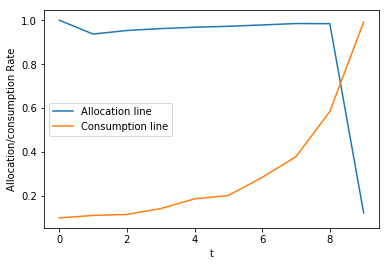

In [192]:
import pylab as pl
last_t = 0
avg_con = np.zeros((10,1))
avg_all = np.zeros((10,1))
counter = np.zeros((10,1))
for s in sorted(policy):
    avg_all[s[0]] += policy[s][0]
    avg_con[s[0]] += policy[s][1]
    counter[s[0]] += 1  

avg_all = np.divide(avg_all, counter)
avg_con = np.divide(avg_con, counter)
# for i in range(avg_all.shape[0]):
#     print(i, avg_all[i], avg_con[i])
pl.plot(np.arange(10), avg_all, label='Allocation line')
pl.plot(np.arange(10), avg_con, label='Consumption line')
pl.xlabel('t')
pl.ylabel('Allocation/consumption Rate')
pl.legend(loc='center left')
pl.show()

### Real World Portfolio Allocation + Consumption Problem


## Appendix Code

In [7]:
from typing import TypeVar

S = TypeVar('S')
A = TypeVar('A')

In [8]:
from typing import NamedTuple, Any, Dict, Tuple, Set, Union
import numpy as np

class MDP(NamedTuple):
    States: Set[S]
    # the transitions depend on s, a, and s'
    # mapping from a state to a mapping of an action to a mapping of a state to a float (probability)
    P: Dict[S, Dict[A, Dict[S, float]]]
    Actions: A
    # reward is a function of the current state,  and the action
    R: Union[Dict[S, Dict[A, float]], Dict[S, Dict[A, Dict[S, float]]]]
    gamma: float

        
class Policy(NamedTuple):
    # state to action to a probability
    pi: Dict[S, Dict[A, float]]
        

class state_value_function(NamedTuple):
    vf: Dict[S,  float]
        
        
class action_value_function(NamedTuple):
    vf: Dict[S, Dict[A, float]]

In [174]:
def async_value_iter(mdp: MDP, n_iter: int) -> state_value_function:
    # implementation of value iteration, the code is very similar to that of policy iteration
    # the difference is what kind of information we store
    v = {s: 0. for s in mdp.States}
    pi = {s: None for s in mdp.P}
    
    for i in range(n_iter):
        # do asynchronous value iteration
        for s in mdp.P:
            # variable to store the best value when looping over the actions
            best_value = -1000000
            best_a = None
            for a in mdp.P[s]:
                # variable for storing the value for action a
                value = mdp.R[s][a]
                for sp in mdp.P[s][a]:
                    value += mdp.gamma * mdp.P[s][a][sp] * v[sp]
                if value > best_value:
                    best_value = value
                    best_a = a
            # store the best value
            v[s] = best_value
            pi[s] = best_a
    return v, pi

In [160]:
def policy_eval(mdp: MDP, policy: Policy, n_iter: int) -> state_value_function:
    # implementation of policy evaluation
    # asynchrounous version
    vf = {s: 0. for s in mdp.States}
    
    for i in range(n_iter):
        for s in mdp.P:
            vf[s] = 0
            for a in mdp.P[s]:
                vf[s] += policy[s][a]*mdp.R[s][a]
                for sp in mdp.P[s][a]:
                    vf[s] += policy[s][a]*mdp.gamma*mdp.P[s][a][sp]*vf[sp]

    return vf

In [163]:
def policy_iter(mdp: MDP, policy: Policy, n_iter: int) -> Policy:
    for i in range(n_iter):
        new_policy = policy
        v = policy_eval(mdp, policy, n_iter)
        for s in mdp.P:
            best_value = -1000000
            best_a: A
            for a in mdp.P[s]:
                # reinitialize the new policy
                new_policy[s][a] = 0.
                value = mdp.R[s][a]
                for sp in mdp.P[s][a]:
                    value += mdp.gamma*mdp.P[s][a][sp]*v[sp]
                if value > best_value:
                    best_value = value
                    best_a = a
            # make the policy deterministic
            new_policy[s][best_a] = 1.0
                    
        policy = new_policy
    return policy